In [8]:
import sys
sys.path.append('/home/moasi/SEE/SEE_decoding/code') 
import mocap_functions
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch as torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
sns.set()
sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0")
device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

In [9]:
video_path = '../data/SPK20220308/motion_tracking'

pos_fnames = f'{video_path}/Spike03-08-1557_DLC3D_resnet50_DLCnetwork3D_Spike03-08-1557Sep7shuffle1_500000_AllCam.csv'

eyes_path = f'{video_path}/SpikeCam5_EYES_03-08-1557DLC_resnet50_DLC-eyesNov4shuffle1_40000_el.csv'

## Load Raw Data

In [10]:
cam_df = pd.read_csv(pos_fnames)

# Subtract wrist marker from fingers
forelimb_markers = ['carpal', 'radiusProx', 'radiusDistal', 'ulnarProx', 'ulnarDistal']
wrist_marker = 'carpal'
forelimb_mask = np.logical_or.reduce([cam_df.columns.str.contains(pat=pat) for pat in forelimb_markers])
finger_mask = np.invert(forelimb_mask)

for marker_name in cam_df.columns[finger_mask]:
    if '_x' in marker_name:
        cam_df[marker_name] = cam_df[marker_name] - cam_df[f'{wrist_marker}_x']
    elif '_y' in marker_name:
        cam_df[marker_name] = cam_df[marker_name] - cam_df[f'{wrist_marker}_y']
        
# Calculate grip aperture
cam_df['grip_aperture'] = np.sqrt(
    np.square(cam_df['thumbDistal_x'] - cam_df['indexProx_x']) + 
    np.square(cam_df['thumbDistal_y'] - cam_df['indexProx_y']))

# Load eyes and concatenate marker information into column names from first 3 rows
eyes_df = pd.read_csv(eyes_path, header=[1,2,3]).iloc[:,1:]
eyes_df.columns = ['_'.join(eyes_df.columns[idx]) for idx in range(len(eyes_df.columns))]

# Add columns from eyes_df
cam_df = pd.concat([cam_df, eyes_df], axis=1)

pos_mask = np.logical_or.reduce((cam_df.columns.str.contains(pat='_x'), cam_df.columns.str.contains(pat='_y'), 
                                 cam_df.columns.str.contains(pat='_z')))
marker_names = cam_df.columns[pos_mask].values.tolist()

In [4]:
# Inspect proportion of NaNs where tracking lost
null_percent = cam_df.isnull().astype(int).sum().values / len(cam_df)
sort_indices = np.argsort(null_percent)[::-1]

for name, val in zip(cam_df.columns[sort_indices], null_percent[sort_indices]):
    print(f'| {name} {np.round(val, 2)}', end=' ')

| pinkyDistal_y 0.99 | pinkyDistal_x 0.99 | pinkyMid_y 0.99 | pinkyMid_x 0.99 | pinkyDistal_z 0.99 | pinkyDistal_error 0.99 | ringDistal_y 0.98 | ringDistal_x 0.98 | pinkyMid_error 0.98 | pinkyMid_z 0.98 | ringMid_x 0.97 | ringMid_y 0.97 | ringTip_x 0.97 | ringTip_y 0.97 | pinkyTip_y 0.96 | pinkyTip_x 0.96 | ringDistal_z 0.96 | ringDistal_error 0.96 | pinkyTip_z 0.96 | pinkyTip_error 0.96 | ringMid_z 0.95 | ringMid_error 0.95 | ringTip_error 0.95 | ringTip_z 0.95 | middleTip_y 0.86 | middleTip_x 0.86 | ulnarProx_z 0.85 | ulnarProx_y 0.85 | ulnarProx_x 0.85 | ulnarProx_error 0.85 | middleTip_error 0.83 | middleTip_z 0.83 | radiusProx_error 0.75 | radiusProx_z 0.75 | radiusProx_y 0.75 | radiusProx_x 0.75 | righteye_pupiltop_y 0.65 | righteye_pupiltop_x 0.65 | indextip_y 0.57 | indextip_x 0.57 | indextip_error 0.53 | indextip_z 0.53 | ulnarDistal_error 0.48 | ulnarDistal_x 0.48 | ulnarDistal_y 0.48 | ulnarDistal_z 0.48 | lefteye_pupiltop_x 0.43 | lefteye_pupiltop_y 0.43 | pinkyProx_y 0.41

In [5]:
# Set threshold for likelihood
score_threshold = 0.5

# Pull out marker names stripped of suffix (only markers have scores and likelihood DLC variables)
score_mask = cam_df.columns.str.contains(pat='_x')
score_names = cam_df.columns[score_mask].values
marker_names_stripped = cam_df.columns[score_mask].str.split('_').str[:-1].str.join('_').values

# marker_pos_names indicates which vars are stored in kinematic_df. Only append _x, _y, _z markers
marker_pos_names = list()
for mrk_name in marker_names_stripped:
    # Separate likelihood and position data for 
    mrk_score_mask = np.logical_and(cam_df.columns.str.contains(pat=mrk_name), 
                                    np.logical_or(cam_df.columns.str.contains(pat='error'), 
                                                  cam_df.columns.str.contains(pat='likelihood')))
    mrk_pos_mask = np.logical_and(cam_df.columns.str.contains(pat=mrk_name), 
                                    np.logical_or.reduce((cam_df.columns.str.contains(pat='_x'), 
                                                          cam_df.columns.str.contains(pat='_y'),
                                                          cam_df.columns.str.contains(pat='_z'))))   
    # There should only be 1 likelihood variable, and 2 or 3 position variables
    assert np.sum(mrk_score_mask) == 1
    assert np.sum(mrk_pos_mask) == 2 or np.sum(mrk_pos_mask) == 3
    mrk_score_name = cam_df.columns[mrk_score_mask].values[0]
    pos_name_list = cam_df.columns[mrk_pos_mask].values.tolist()
    marker_pos_names.extend(pos_name_list)

    score_data = cam_df[mrk_score_name].values
    threshold_mask = score_data < score_threshold

    # Set position data values to zero if likelihood below threshold
    for pos_name in pos_name_list:
        pos_data = cam_df[pos_name]
        pos_data[threshold_mask] = 0.0

        # Remove nans (need to test with interpolation)
        pos_data = np.nan_to_num(pos_data, copy=True, nan=0.0)
        
        # Update dataframe
        cam_df[pos_name] = pos_data

In [11]:
cb_dict = dict()
unit_idx = 0
for cb_idx in range(1,3):
    #Use neo module to load blackrock files
    fpath = '../data/SPK20220308/task_data/'
    # TODO: Fix this
    if cb_idx == 1:
        experiment_dict = sio.loadmat(f'{fpath}eventsCB{cb_idx}_corrected.mat')
    else:
        experiment_dict = sio.loadmat(f'{fpath}SPKRH20220308_CB{cb_idx}_ev_explicit.mat')
    nev = neo.io.BlackrockIO(f'{fpath}SPKRH20220308_CB{cb_idx}_quiver4toyPKPK4Rotation_delay_001_RETVR_DSXII_corrected.nev')
    ns2 = neo.io.BlackrockIO(f'{fpath}SPKRH20220308_CB{cb_idx}_quiver4toyPKPK4Rotation_delay_001.ns2')

    sampling_rate_list = ns2.header['signal_channels'][['name','sampling_rate']]
    sampling_rate = 30000
    analog_sampling_rate = 1000
    eye_sampling_rate = 500
    camera_sampling_rate = 40

    #nev seg holds spike train information to extract
    nev_seg = nev.read_segment()
    tstart = nev_seg.t_start.item()
    tstop = nev_seg.t_stop.item()

    #Group spiketrain timestamps by unit id
    unit_timestamps = dict()
    for st in nev_seg.spiketrains:
        if st.annotations['unit_id'] == 1:
            unit_timestamps[unit_idx] = st.times
            unit_idx += 1

    #Grab indeces for camera frames
    cam_trigger = ns2.get_analogsignal_chunk(channel_names=['FlirCam']).transpose()[0]
    num_analog_samples = len(cam_trigger)
    trigger_val = 18000 #threshold where rising edge aligns frame, may need to tweak
    cam_frames = np.flatnonzero((cam_trigger[:-1] < trigger_val) & (cam_trigger[1:] > trigger_val))+1

    cb_dict[f'cb{cb_idx}'] = {'tstart': tstart, 'tstop': tstop, 'unit_timestamps': unit_timestamps,
                              'cam_frames': cam_frames, 'experiment_dict': experiment_dict}


In [7]:
cb_dict

{'cb1': {'tstart': 0.0033333333333333335,
  'tstop': 4131.0003,
  'unit_timestamps': {0: array([4.08333333e-02, 9.77000000e-02, 2.51966667e-01, ...,
          4.13089153e+03, 4.13095137e+03, 4.13099620e+03]) * s,
   1: array([2.73000000e-02, 2.15266667e-01, 3.17800000e-01, ...,
          4.13076083e+03, 4.13087670e+03, 4.13097173e+03]) * s,
   2: array([1.46033333e-01, 1.64566667e-01, 2.28733333e-01, ...,
          4.13005577e+03, 4.13018443e+03, 4.13022210e+03]) * s,
   3: array([8.83333333e-03, 2.38000000e-02, 1.35500000e-01, ...,
          4.13094383e+03, 4.13096263e+03, 4.13098663e+03]) * s,
   4: array([1.53333333e-02, 7.80333333e-02, 1.35166667e-01, ...,
          4.13088600e+03, 4.13093363e+03, 4.13097837e+03]) * s,
   5: array([3.80400000e-01, 1.40603333e+00, 1.69493333e+00, ...,
          4.12904647e+03, 4.12998090e+03, 4.13073437e+03]) * s,
   6: array([7.62200000e-01, 1.88806667e+00, 1.91763333e+00, ...,
          4.11260920e+03, 4.11277523e+03, 4.12614583e+03]) * s,
   7: a

In [12]:
experiment_dict = cb_dict['cb1']['experiment_dict']
cam_frames =  cb_dict['cb1']['cam_frames']

#Load variables from struct (struct indexing is unfortunately hideous)
#ev_ex = experiment_dict['df']
ev_ex = experiment_dict['eventsCB1']
gocON = ev_ex['gocON'][0][0][0]
#gocOFF = ev_ex['gocOFF'][0][0][0]
#stmv = ev_ex['stmv'][0][0][0]
contact = ev_ex['contact_C'][0][0][0]
end_hold = ev_ex['endhold_C'][0][0][0]
layout = ev_ex['LAYOUT_C'][0][0][0] # Inserts layout into dataframe
position = ev_ex['POSITION_C'][0][0][0]
# TODO: Load structure into matlab, find variable names, copy into here, pull out position object etc
#   Use cb1
# Google slide(?) w example of spike and contact with video frame
# cam_frames should be aligned with video: find index in cam frame closest to contact time
# Look for end_lift: sensor detect when pulled, not just when touched

#reward = ev_ex['reward'][0][0][0]
#error = ev_ex['error'][0][0][0]

In [13]:
#Define game event for alignment, and window around marker
event_ts = end_hold
#event_ts = event_ts[event_ts < 1000] # events less than 1000 seconds for short DLC tracking
e_start, e_stop = [0,2]
num_events = len(event_ts)

In [14]:
# Find scale/timeshift between CB1 and CB2
cb2_align_ts = cb_dict['cb2']['experiment_dict']['df']['gocON'][0][0][0]
assert len(cb2_align_ts) == len(gocON) 
cb2_start, cb2_end = cb2_align_ts[0], cb2_align_ts[-1]

ts_shift = gocON[0] - cb2_start 
ts_scale = (cb2_end - cb2_start) / (gocON[-1] -  gocON[0])


In [15]:
unit_timestamps = cb_dict['cb1']['unit_timestamps'].copy()

# Shift and scale time stamps between the two machines
unit_timestamps_cb2 = cb_dict['cb2']['unit_timestamps'].copy()
unit_timestamps_cb2_corrected = dict()
for unit_idx, unit_ts in unit_timestamps_cb2.items():
    ts_corrected = (unit_ts + ts_shift * (pq.s)) / (ts_scale * pq.s)
    unit_timestamps_cb2_corrected[unit_idx] = ts_corrected


unit_timestamps.update(unit_timestamps_cb2_corrected)


In [25]:
#Append convolved firing rates to dataframe
kernel_halfwidth = 0.250 #in seconds
kernel = elephant.kernels.RectangularKernel(sigma=kernel_halfwidth/np.sqrt(3)*pq.s)  #***** Change if you want Carlos
sampling_period = 0.01*pq.s
window_length = int((e_stop-e_start)/(sampling_period).item())
    
#List to store neural data
rate_col = list()
unit_col = list()
trial_col_neural = list()
layout_col_neural = list()
position_col_neural = list()

#List to store kinematic data
posData_col = list()
name_col = list()
trial_col_kinematic = list()
layout_col_kinematic = list()
position_col_kinematic = list()

#List to store video data
timeStamps_col = list()
trial_col_video = list()
layout_col_video = list()
position_col_video = list()


kinematic_metadata = dict()
neural_metadata = dict()
for e_idx, e_ts in enumerate(event_ts):
    print(e_idx, end=' ')
    
    #Load kinematic data
    #Identify which frames fall in the time window
    frame_mask = np.logical_and(cam_frames > ((e_ts+e_start) * analog_sampling_rate), cam_frames < ((e_ts+e_stop) * analog_sampling_rate))
    frame_idx = np.flatnonzero(frame_mask) #Pull out indeces of valid frames
    kinematic_metadata[e_idx] = {'time_data':np.linspace(e_ts+e_start, e_ts+e_stop, window_length)}
    
    for mkr in marker_pos_names:
        marker_pos = cam_df[mkr].values[frame_idx]
        f = interp1d(np.linspace(0,1,marker_pos.size), marker_pos)
        marker_interp = f(np.linspace(0,1,window_length))
        
        posData_col.append(marker_interp)
        name_col.append(mkr)
        trial_col_kinematic.append(e_idx)
        layout_col_kinematic.append(layout[e_idx])
        
        position_col_kinematic.append(position[e_idx])
    
    #Load neural data
    # use as its own 2d matrix
    unit_rate = list()
    for unit_idx, unit_ts in unit_timestamps.items():
        rate = spike_train_functions.spike_train_rates(unit_ts, e_ts+e_start, e_ts+e_stop, sampling_rate, kernel, sampling_period).transpose()
        
        rate_col.append(rate)
        trial_col_neural.append(e_idx)
        layout_col_neural.append(layout[e_idx])
        unit_col.append(unit_idx)
        neural_metadata[e_idx] = {'time_data':frame_idx}
        position_col_neural.append(position[e_idx])
    # TODO: Ask about this
    # all_rates.append(unit_rate)

    timeStamps_col.append((e_ts+e_start, e_ts+e_stop))
    trial_col_video.append(e_idx)
    layout_col_video.append(layout[e_idx])
    position_col_video.append(position[e_idx])
        
#Pickle convolved rates
neural_dict = {'rates':rate_col, 'unit':unit_col, 'trial':trial_col_neural, 'layout': layout_col_neural, 'position':position_col_neural}
neural_df = pd.DataFrame(neural_dict)
neural_df['count'] = neural_df['rates'].apply(np.sum)


kinematic_dict = {'name':name_col, 'posData':posData_col, 'trial':trial_col_kinematic, 'layout': layout_col_kinematic, 'position':position_col_kinematic}
kinematic_df = pd.DataFrame(kinematic_dict)

video_dict = {'timeStamps':timeStamps_col, 'trial': trial_col_video, 'layout': layout_col_video, 'position': position_col_video}
video_df = pd.DataFrame(video_dict)

metadata={'kinematic_metadata':kinematic_metadata, 'neural_metadata':neural_metadata, 'num_trials':num_events, 'kernel_halfwidth':kernel_halfwidth}


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 

In [26]:
video_df

,timeStamps,trial,layout,position
0,"(27.626633333333334, 29.626633333333334)",0,1,2
1,"(40.23863333333333, 42.23863333333333)",1,4,4
2,"(53.001333333333335, 55.001333333333335)",2,2,3
3,"(65.30276666666667, 67.30276666666667)",3,3,4
4,"(77.99893333333333, 79.99893333333333)",4,1,3
...,...,...,...,...
213,"(4048.1054, 4050.1054)",213,1,3
214,"(4071.8425, 4073.8425)",214,1,1
215,"(4084.255166666667, 4086.255166666667)",215,4,2
216,"(4093.8241333333335, 4095.8241333333335)",216,4,2


In [56]:
#Save DataFrames to temporary folder
kinematic_df.to_pickle(fpath + 'kinematic_df.pkl')
neural_df.to_pickle(fpath + 'neural_df.pkl')

#Save metadata
output = open(fpath + 'metadata.pkl', 'wb')
pickle.dump(metadata, output)
output.close()

## Analyze Data

In [ ]:
Tuple first is example to feed into nework, 

In [57]:
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/')

sampling_rate = 100
kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
neural_offset = 20
offset = neural_offset + kernel_offset
window_size = 20
data_step_size = 1 

num_trials = metadata['num_trials']



#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [101]:
kinematic_df

,name,posData,trial,layout,position
0,thumbProx_x,"[13.952238682069947, 8.203075004031074, 2.4539...",0,1,2
1,thumbProx_y,"[-136.26687285358105, -80.11670414004513, -23....",0,1,2
2,thumbProx_z,"[8102.69678361441, 4763.8971039341, 1425.09742...",0,1,2
3,thumbDistal_x,"[-231.12634198253, -135.8883518188744, -40.650...",0,1,2
4,thumbDistal_y,"[-352.94247942093307, -207.5088949359255, -62....",0,1,2
...,...,...,...,...,...
22231,lefteye_pupilbottom_y,"[520.859, 520.3612311557789, 519.8634623115578...",217,2,2
22232,lefteye_pupiloutside_x,"[974.431, 974.4507788944724, 974.4705577889448...",217,2,2
22233,lefteye_pupiloutside_y,"[504.5, 504.58818090452263, 504.6763618090452,...",217,2,2
22234,single_cornealRefR_x,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",217,2,2


In [28]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
import itertools

In [60]:
class Video_Dataset(torch.utils.data.Dataset):
    def __init__(self, video_path, subsample_scalar=1):
        self.video_path = video_path
        self.reader = torchvision.io.VideoReader(video_path, "video")
        self.md = self.reader.get_metadata()
        self.subsample_scalar = subsample_scalar
        # super().__init__()
    
    
    '''
    Allows time indexing (s) into videos, returns relevant frames. Note that 
    indexes must be floats.

    Returns list(np.array)
    '''
    def __getitem__(self, key):
        if isinstance(key, float):
            time_stamp = key
            self.reader.seek(time_stamp)
            # TODO: NB we are throwing out two color channels
            frames = [np.moveaxis(np.array(next(self.reader)['data']), 0, 2)[::self.subsample_scalar,::self.subsample_scalar,0] / 255.0]
        
        elif isinstance(key, tuple):
            start, stop = key
            frames = []
            self.reader.set_current_stream("video")
            video = self.reader.seek(start)

            for frame in itertools.takewhile(lambda x: x['pts'] <= stop, video):
                frames.append(np.moveaxis(np.array(frame['data']), 0, 2)[::self.subsample_scalar,::self.subsample_scalar,0] / 255.0)

        else:
            raise TypeError("Key must be a float or a tuple of floats.")
        return frames

    """
    Given frames, print them
    """
    def print_frames(self, frames, step=1):
        num_frames = len(frames)
        if num_frames > 1:
            fig, axes = plt.subplots(nrows=1, ncols= -(num_frames // -step), figsize=(24,24))
            i=0
            for n in range(0, num_frames, step):
                #curr_ax = axes[i//8, i%8] 
                curr_ax = axes[i] 
                curr_ax.imshow(frames[n])
                i+=1
            return fig
        else:
            plt.imshow(frames[0])
    
    """
    Given time stamp(s), prints the frames at those timestamps
    """
    def print_frame_at_time(self, time_stamp, step=1):
        frames = self[time_stamp]
        fig = self.print_frames(frames, step)
        return fig

In [42]:
array = np.array([
    [[1, 2, 3, 4, 5, 6],
    [1, 2, 5, 4, 7, 8],
    [2, 3, 4, 5, 6, 8]],
    [[1, 2, 3, 4, 5, 6],
    [1, 2, 5, 4, 7, 8],
    [2, 3, 4, 5, 6, 8]]
])
print(np.shape(array))
array[0, ::1, ::1]

(2, 3, 6)


array([[1, 2, 3, 4, 5, 6],
       [1, 2, 5, 4, 7, 8],
       [2, 3, 4, 5, 6, 8]])

# Visualize Data

Text(0, 0.5, 'Marker position')

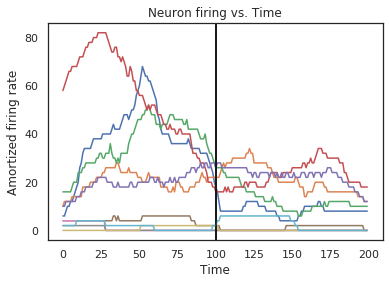

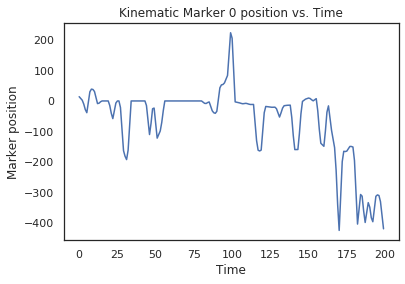

In [58]:
# TODO: Multiple rows with same trial, each unit is each individual recorded neuron
#       Each trial is 86 neurons recorded, for each convolved time-series firing rate
#       to pull specific 
#   Kinematic df- name of marker instead of unit, 20ish markers per trial

# Number of plots
n = 10

for i in range(n):
    plt.plot(neural_df['rates'].values[i].squeeze())
    plt.title('Neuron firing vs. Time')
    plt.axvline(x=100, color='k')
    plt.xlabel('Time')
    plt.ylabel('Amortized firing rate')

plt.figure()
plt.title('Kinematic Marker 0 position vs. Time')
plt.plot(kinematic_df['posData'].values[0].squeeze())
plt.xlabel('Time')
plt.ylabel('Marker position')

In [59]:
#fig, ax = plt.subplots(2,2, figsize=(6,6), subplot_kw=dict(projection='3d'))

thumb_data_x = kinematic_df[kinematic_df['name'] == 'thumbProx_x'][['posData', 'position', 'layout']].squeeze() 
thumb_data_y =  kinematic_df[kinematic_df['name'] == 'thumbProx_y'][['posData', 'position', 'layout']].squeeze()
thumb_data_z = kinematic_df[kinematic_df['name'] == 'thumbProx_z'][['posData', 'position', 'layout']].squeeze()

np.vstack(thumb_data_x['posData'].values).shape

# for i, (rowx, rowy, rowz) in enumerate(zip(thumb_data_x.rows, thumb_data_y.rows, thumb_data_z.rows)):
#     xdata = rowx
#     ydata = 
#     zdata = 
#     if row['position'] == 1:
#         ax[0,0].scatter3D()
#     elif row['position'] == 2:
#         ...
#     elif row['position'] == 3:
#         ...
#     else:
#         ...

#ax[0,0].scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')


(218, 200)

In [61]:
from mpl_toolkits.mplot3d import Axes3D

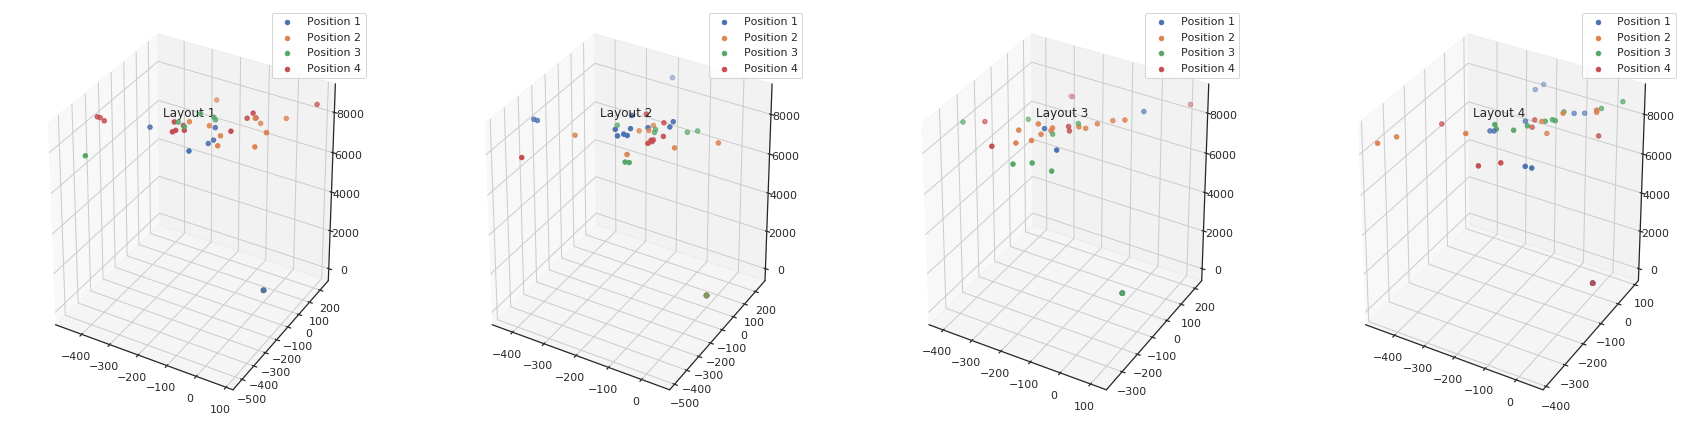

In [73]:
fig, ax = plt.subplots(1,4, figsize=(30,7.5), subplot_kw=dict(projection='3d'))
plot_types = [(idx1, idx2) for idx1 in range(1,5) for idx2 in range(1,5)]

plot_data = [thumb_data_x, thumb_data_y, thumb_data_z]
for plot_type in plot_types:
    mask = pd.array(np.logical_and(thumb_data_y['layout']==plot_type[0], thumb_data_y['position']==plot_type[1]))
    # for data in plot_data[1:]:
    #     assert mask ==  np.logical_and(data['layout']==plot_type[0], data['position']==plot_type[1])
    
    thumb_data_x_filtered = thumb_data_x[mask]['posData'].str[0]
    thumb_data_y_filtered = thumb_data_y[mask]['posData'].str[0]
    thumb_data_z_filtered = thumb_data_z[mask]['posData'].str[0]

    ax[plot_type[0]-1].scatter3D(thumb_data_x_filtered, thumb_data_y_filtered, thumb_data_z_filtered, label = 'Position ' + str(plot_type[1]))
    ax[plot_type[0]-1].set_title('Layout ' + str(plot_type[0]))
    ax[plot_type[0]-1].legend()
    

## Visualize Video Data

(1, 106, 144)


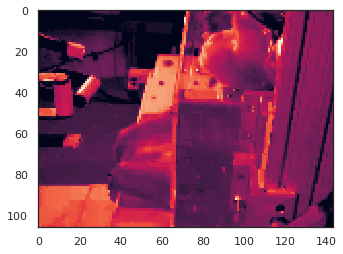

In [64]:
video_path = "/home/moasi/SEE/SEE_decoding/data/SpikeCam1_03-08-1557_cam1DLC_resnet50_DLCnetwork_Spike0308_1557Aug24shuffle1_350000_filtered_labeled.mp4"
video = Video_Dataset(video_path, subsample_scalar=10)
print(np.shape(video[0.0]))
video.print_frame_at_time(0.0)

(42, 352, 480)


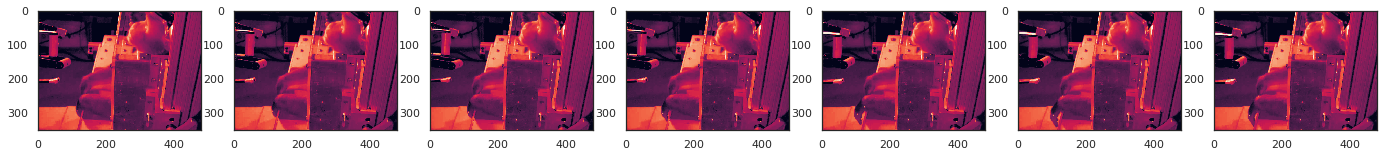

In [59]:
video_path = "/home/moasi/SEE/SEE_decoding/data/SpikeCam1_03-08-1557_cam1DLC_resnet50_DLCnetwork_Spike0308_1557Aug24shuffle1_350000_filtered_labeled.mp4"
video = Video_Dataset(video_path, subsample_scalar=3)
video.print_frame_at_time((2.0, 2.5), step=3)

frames = video[0,1]
print(np.shape(frames))

In [65]:
video_df

,timeStamps,trial,layout,position
0,"(27.626633333333334, 29.626633333333334)",0,1,2
1,"(40.23863333333333, 42.23863333333333)",1,4,4
2,"(53.001333333333335, 55.001333333333335)",2,2,3
3,"(65.30276666666667, 67.30276666666667)",3,3,4
4,"(77.99893333333333, 79.99893333333333)",4,1,3
...,...,...,...,...
213,"(4048.1054, 4050.1054)",213,1,3
214,"(4071.8425, 4073.8425)",214,1,1
215,"(4084.255166666667, 4086.255166666667)",215,4,2
216,"(4093.8241333333335, 4095.8241333333335)",216,4,2


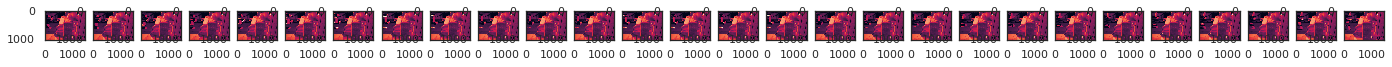

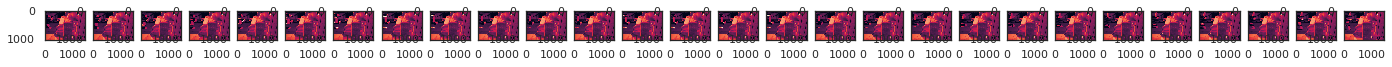

In [30]:
video_path = "/home/moasi/SEE/SEE_decoding/data/SpikeCam1_03-08-1557_cam1DLC_resnet50_DLCnetwork_Spike0308_1557Aug24shuffle1_350000_filtered_labeled.mp4"
video = Video_Dataset(video_path)
ts = video_df['timeStamps'][0]
video.print_frame_at_time(ts, step=3)

Baseline: average firing rate for each of 16 conditions without the one being predicted
    r^2, mse, correlation of ^

Write-up
    Lit search
    Carlos will send outline
    Define problem
    Description of data
    Analysis and Methods
        Baseline
        Architectures
    Results
        Quantitative
        Which neurons can predict well?
            Visualize the distributions, compare to baseline
        Chance distribution: Shuffle trials
            Montecarlo methods estimate chance of some metric-> above chance? matched pair better than 
            Empirical chance distribution
            Is there a subset(s) above chance?
                Cortical area
                    Plot % vs R^2

Start: 1 frame -> all neurons at that point
Submit updates as pull request to original repo: make branch, checkout, push
Use paperpile for references- works with google docs


Row number not as meaningful: each is time slice
Check out pandas filtering:
   kinematic_df[kinematic_df['name'] == 'thumbProx_x']
Can use logical operators, eg:
   kinematic_df[np.logical_and(kinematic_df['name'] == 'thumbProx_x', kinematic_df['name'] == 'thumbProx_y')]
Mapping operations

TO DO for 11/11
- Get snapshots from video?
- Try plots of different markers
- Make sure that position and layout arent confused
- Video loader:
   -> Something that takes in videodata, out neuron fr
   -> Start without DR
   -> define index/frame, get portion of video
   -> Same indexing as contact points/trial/cells
   -> plots frame of video
   -> use _getitem for indexing video
   -> Wiener filter?
   -> get pipeline together

TO-DO for next week 10/28:
-Contact point plot: Marker (thumb and index?) location at point of contact
    -> Carefully choose which one plotting, some tracking bad
    -> Position, object, orientation for each of 16 conditions
    -> How much overlap between conditions
    -> One layout at a time (4 plots)
    -> Color by object being grasped


Long term:
    Start writing code for data loader class: video loader, act like np array, index, spit out processed frame
    Look at different video formats: mp4 vs raw
    Package: Open CV (import cv2)
    Try training on MLP, even linear regression, see if can get working, then can expand and use more complicated architectures



read_video(filename[,start_pts, end_pts,...])
Reads a video from a file, returning both the video frames as well as audio frames
read_video_timestamps(filename[,pts_unit]) list the video frames timestamps

[T,H,W,C]??

In [71]:
# Set up PyTorch Dataloaders
fold=0
kinematic_type = 'posData'
# Parameters
batch_size = 10000
train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

predict_kinematics=False
# Generators
training_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'train_idx', kinematic_df, neural_df, offset, window_size, 
                                            data_step_size, device, 'posData', True, predict_kinematics)
training_generator = torch.utils.data.DataLoader(training_set, **train_params)
training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

validation_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'validation_idx', kinematic_df, neural_df, offset, window_size, 
                                                data_step_size, device, 'posData', True, predict_kinematics)
validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

testing_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'test_idx', kinematic_df, neural_df, offset, window_size, 
                                                data_step_size, device, 'posData', True, predict_kinematics)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

In [ ]:
training_set[10][0].shape
# First is different markers, second is 

11/26 start with window size 1
cv_dict -> which trials belong to which fold
video df but where kinematic is timestamps, in get item pull from
mocap functions SEE_Dataset
store torch video loader
One row, trial, frame indices
create bare bones dataset
index, pulls out frame at time point

In [68]:
neural_list = list()
video_list = list()
for trial_idx in range(10):
    neural_list.append(neural_df[neural_df['trial'] == trial_idx]['rates'].values.squeeze())
    video_list.append(video_df[video_df['trial'] == trial_idx]['timeStamps'].values.squeeze())


[array([array([[ 6.,  6.,  8., 10., 10., 12., 12., 14., 16., 18., 20., 26., 28.,
                32., 34., 34., 34., 34., 34., 36., 38., 38., 38., 38., 38., 38.,
                40., 40., 40., 40., 40., 40., 42., 44., 42., 42., 42., 42., 44.,
                46., 48., 48., 48., 46., 48., 50., 50., 52., 56., 58., 60., 64.,
                68., 66., 64., 64., 62., 62., 60., 58., 56., 54., 48., 46., 42.,
                40., 40., 40., 40., 40., 38., 36., 36., 36., 36., 36., 36., 36.,
                36., 36., 36., 36., 38., 36., 34., 34., 34., 34., 34., 34., 32.,
                32., 32., 32., 32., 30., 28., 26., 24., 20., 18., 16., 12.,  8.,
                 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
                 8., 10., 10., 12., 12., 12., 12., 12., 12., 12., 12., 10., 10.,
                10., 10., 10.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  6.,  6.,  4.,
                 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  6.,  6.,
                 8.,  8., 10

Kalman Filter decoding

In [ ]:
#Fit and run kalman filter
model_kf = Neural_Decoding.decoders.WienerFilterDecoder() 
model_kf.fit(X_train_data,y_train_data)

kf_train_pred = model_kf.predict(X_train_data)
kf_test_pred = model_kf.predict(X_test_data)

#Compute decoding performance
kf_train_corr = mocap_functions.matrix_corr(kf_train_pred,y_train_data)
kf_test_corr = mocap_functions.matrix_corr(kf_test_pred,y_test_data)


: 

In [ ]:
%matplotlib inline
plt.imshow(kf_test_pred,aspect='auto')

: 

: 

ANN Decoding

In [ ]:
#Define hyperparameters
lr = 1e-2
weight_decay = 1e-5
layer_size=[10, 10]
max_epochs=1000
input_size = training_set[0][0].shape[1] 
output_size = training_set[0][1].shape[1] 

model_ann = mocap_functions.model_ann(input_size,output_size,layer_size).to(device)
# Define Loss, Optimizerints h
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ann.parameters(), lr=lr, weight_decay=weight_decay)

: 

In [ ]:
#Train model
loss_dict = mocap_functions.train_validate_model(model_ann, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

: 

In [ ]:
#Evaluate trained model
ann_train_pred = mocap_functions.evaluate_model(model_ann, training_eval_generator, device)
ann_test_pred = mocap_functions.evaluate_model(model_ann, testing_generator, device)

#Compute decoding performance
ann_train_corr = mocap_functions.matrix_corr(ann_train_pred,y_train_data)
ann_test_corr = mocap_functions.matrix_corr(ann_test_pred,y_test_data)


: 

Visualize Results

In [ ]:
#Testing Data
start=23
plt.figure(figsize=(12,8))
bounds = np.arange(1,2000)
x_vals = np.arange(len(bounds)) / 100
for plot_idx, unit_idx in enumerate(range(start, start+4)):
    plt.subplot(2,2,plot_idx+1)
    plt.plot(x_vals,y_test_data[bounds,unit_idx])
    plt.plot(x_vals,kf_test_pred[bounds,unit_idx])
    plt.plot(x_vals,ann_test_pred[bounds,unit_idx])
    plt.title('Unit ' + str(unit_idx))
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (a.u.)')
    if plot_idx==1:
        plt.legend(['Real', 'KF', 'ANN'], loc=1)
plt.tight_layout()

: 

: 